In [1]:
import ast
import os
import re
import warnings
from typing import List

import joblib
import yaml

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from lightgbm import LGBMRegressor

from tqdm.notebook import tqdm
import optuna
from optuna import Study
from optuna.visualization.matplotlib import plot_optimization_history, \
                plot_param_importances
from transliterate import translit

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", category=RuntimeWarning)
sns.set()

# Описание задачи

**Общая цель проекта:** Создание веб-приложения для анализа, обучения модели и предсказания сборов фильмов в США на основе данных, полученных с сайта Кинопоиск. Используется FastAPI для backend и Streamlit для frontend.

**Цель текущего ноутбука:** 
Подготовить данные для моделирования, обучить базовую предсказательную модель и провести её тюнинг для улучшения результатов.

# Импорт данных

In [2]:
config_path = '../config/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

preproc = config['preprocessing']
train = config['train']

Описание полей:

- **movie_id** - уникальный идентификатор фильма.
- **movie_name** - название фильма.
- **year** - год выпуска фильма.
- **votes_kp, votes_imdb** - количество оценок фильма на Кинопоиске и IMDB.
- **rating_kp, rating_imdb** - рейтинги фильма на Кинопоиске и IMDB.
- **votes_filmCritics** - количество оценок кинокритиков в мире
- **rating_filmCritics** - рейтинг кинокритиков в мире
- **votes_await** - количество ожидающих фильм на Кинопоиске
- **movieLength** - длина фильма
- **ageRating, ratingMpaa** - возрастные рейтинги фильма
- **type** - тип картины (фильм/мультфильм)
- **genres** - жанры фильма
- **countries** - страны фильма
- **fees_usa** - сборы фильма в мире, США, России
- **fees_world_currency и т.д.** - валюта сборов фильма
- **budget** - бюджет и валюта бюджета фильма
- **videos_trailers_number** - количество трейлеров
- **Production** - студии производства
- **Special_effects** - студии спецэффектов
- **actor_metric** - метрики актеров
- **director_metric** - метрики режиссеров
- **writer_metric** - метрики сценристов

**Примечание относительно специфических данных в датасете**

В этом ноутбуке используются данные, которые были получены в рамках исследовательского проекта, где был выполнен обширный анализ и парсинг информации с сайта Кинопоиск. 

Отдельно производился расчет метрик персон, таких как вклад актеров, режиссеров и сценаристов в успех фильмов, для колонок `actor_metric`, `director_metric` и `writer_metric`. Эти метрики были рассчитаны в другом проекте и представляют собой результат сложного процесса анализа данных.

Детальную информацию о том, как был осуществлен парсинг данных, их преобразование, а также расчет указанных метрик можно посмотреть в данном проекте: https://github.com/maria-2397/BoxOfficePredictor-Kinopoisk

In [3]:
df = pd.read_csv(preproc['original_data_path'], sep=preproc['data_separator'])
df[:5].T

,0,1,2,3,4
movie_id,535341,1143242,462682,251733,1188529
movie_name,1+1,Джентльмены,Волк с Уолл-стрит,Аватар,Достать ножи
year,2011,2019,2013,2009,2019
votes_kp,1678838.0,1524128.0,1125382.0,1014540.0,953836.0
votes_imdb,895482.0,372380.0,1471424.0,1359191.0,742208.0
votes_filmCritics,130.0,277.0,289.0,335.0,474.0
votes_await,15.0,13642.0,43024.0,38689.0,9141.0
rating_kp,8.813,8.562,7.976,7.972,8.102
rating_imdb,8.5,7.8,8.2,7.9,7.9
rating_filmCritics,6.8,6.5,7.8,7.4,8.3


In [4]:
df.shape

(4816, 24)

# Распределение целевой переменной

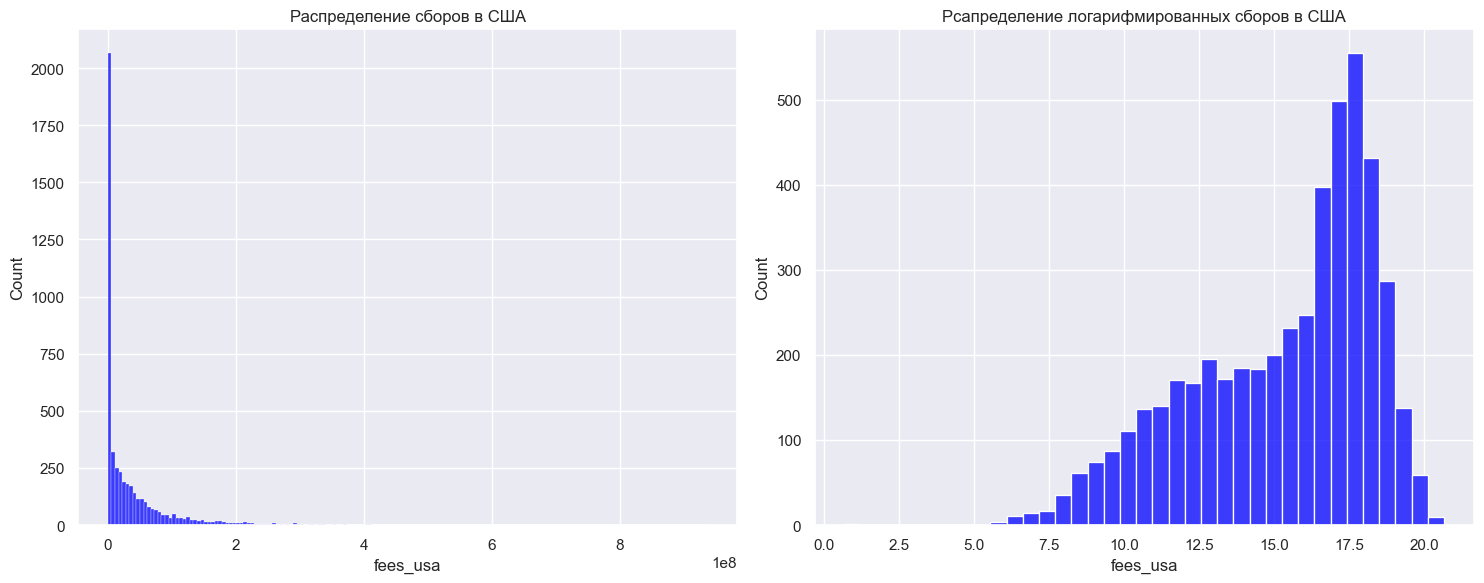

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Первый график для исходной переменной
sns.histplot(df.fees_usa, color='blue', ax=axes[0])
axes[0].set_title('Распределение сборов в США')

# Второй график для логарифмированной переменной
sns.histplot(np.log1p(df.fees_usa), color='blue', ax=axes[1])
axes[1].set_title('Рсапределение логарифмированных сборов в США')

plt.tight_layout()
plt.show();

Целевая переменная имеет длинный правый хвост. Распределение асимметричное. 


Для обучения будем использовать логарифмированную переменную, чтобы предсказания сборов не были отрицательными. 

Также используем функцию потерь, устойчивую к выбросам и ненормальному распределению - MAE (Mean Absolute Error)

# Преобразование данных

In [6]:
class DataFrameTransformer:
    """
    Класс для выполнения преобразований над DataFrame.
    Включает в себя добавление новых признаков, 
    бинаризацию колонок и очистку названий колонок.
    """

    def __init__(self, df: pd.DataFrame, year: int, p: float,
                 cols_to_drop: List[str], dummy_cols: List[str], target_col: str,
                log_target: bool):
        """
        Инициализация класса с dataframe и параметрами преобразования.

        Параметры:
        - df (pd.DataFrame): Входной dataframe.
        - year (int): Текущий год для расчета возраста фильма.
        - p (float): Порог дисперсии для фильтрации бинаризованных колонок.
        - cols_to_drop (List[str]): Колонки для удаления из dataframe.
        - dummy_cols (List[str]): Колонки для бинаризации.
        - target_col (str): Имя колонки с целевой переменной.
        - log_target (bool): условие логарифмирования целевой переменной.
        """

        self.df = df.copy()
        self.year = year
        self.p = p
        self.cols_to_drop = cols_to_drop
        self.dummy_cols = dummy_cols
        self.log_target=log_target
        self.target_col = target_col

    def transform(self) -> pd.DataFrame:
        """Выполняет ряд преобразований над dataframe."""

        self.add_movie_age() 
        self.log_target_col()
        self.series_to_type_list() 
        self.add_dummies() 
        self.drop_unnecessary_cols() 
        self.convert_to_category()  
        self.transform_cols()  
        
        return self.df
    
    def log_target_col(self) -> None:
        """Логарифмирование целевой переменной"""
        if self.log_target:
            self.df[self.target_col] = np.log1p(self.df[self.target_col])

    def add_movie_age(self) -> None:
        """Добавление признака возраста фильма"""
        self.df['movie_age'] = self.year - self.df.year
        del self.df['year']
        
    def series_to_type_list(self) -> None:
        """Преобразование колонок в тип список"""
        for col in self.dummy_cols:
            self.df[col] = self.df[col].fillna('[]')
            self.df[col] = self.df[col].apply(
                lambda x: x if isinstance(x, list) else ast.literal_eval(x))

    def add_dummies(self) -> None:
        """Бинаризует указанные колонки в dataframe.
           Добавляет только те, дисперсия которых выше заданного порога.
        """
        for col in self.dummy_cols:

            dummies = self.make_dummies(col)
            filtered_dummies = self.filter_dummies_by_variance(dummies)
            self.df = pd.concat([self.df, filtered_dummies], axis=1)

    def make_dummies(self, col: str) -> pd.DataFrame:
        """
        Создает бинаризованные колонки для указанного признака в dataframe.
        """
        dummies = self.df[col].str.join('|').str.get_dummies(sep='|')
        return dummies

    def filter_dummies_by_variance(self,
                                   dummies: pd.DataFrame) -> pd.DataFrame:
        """Фильтрация бинаризованных колонок по порогу дисперсии"""
        threshold = self.p * (1 - self.p)
        selector = VarianceThreshold(threshold=threshold)
        selector.fit(dummies)

        return dummies[dummies.columns[selector.get_support(indices=True)]]

    def drop_unnecessary_cols(self) -> None:
        """Удаление ненужных колонок"""
        self.df = self.df.drop(self.cols_to_drop, axis=1)

    def convert_to_category(self) -> None:
        """Преобразование колонок типа object в тип category"""
        cat_cols = self.df.select_dtypes('object').columns
        self.df[cat_cols] = self.df[cat_cols].astype("category")

    # Блок функций для преобразования названий колонок
    def transform_cols(self) -> None:
        """Пайплайн преобразования названий колонок"""
        self.translit_column_names()
        self.replace_spaces_with_underscores()
        self.clean_column_names()

    def translit_column_names(self) -> None:
        """Перевод названий колонок в латинские буквы"""
        self.df.columns = [
            translit(x, language_code='ru', reversed=True)
            for x in self.df.columns
        ]

    def replace_spaces_with_underscores(self) -> None:
        """Замена пробелов в названиях колонок на нижние подчеркивания"""
        self.df.columns = [col.replace(' ', '_') for col in self.df.columns]

    def clean_column_names(self) -> None:
        """Фильтарция названий колонок. Остаются только следующие символы:
            нижние подчеркивания, англ. буквы и цифры"""
        self.df = self.df.rename(
            columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [7]:
transformer = DataFrameTransformer(df, 
                                   year=2019, 
                                   p=0.018,
                                   cols_to_drop=preproc["drop_columns"],
                                   dummy_cols=preproc["dummies"]["columns"],
                                   log_target=preproc["log_target"],
                                   target_col=preproc["target_column"]
                                  )
df = transformer.transform()

# Baseline

In [8]:
def r2_adjusted(y_true: np.ndarray, y_pred: np.ndarray,
                x_test: np.ndarray) -> float:
    """Коэффициент детерминации (множественная регрессия)"""
    n_objects = len(y_true)
    n_features = x_test.shape[1]
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (n_objects - 1) / (n_objects - n_features - 1)


def wape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Weighted Absolute Percent Error"""
    return np.sum(np.abs(y_pred - y_true)) / np.sum(y_true) * 100


def create_dict_metrics(
        y_test: pd.Series,
        y_predict: pd.Series,
        x_test: pd.DataFrame,
        target_is_log: bool) -> dict:
    """
    Получение словаря с метриками для задачи регрессии и запись в словарь
    :param y_test: реальные данные
    :param y_predict: предсказанные значения
    :param x_test: матрица признаков для r2_adjusted
    :param target_is_log: логарифмирование целевой переменной, если необходимо
    :return: словарь с метриками
    """
    if target_is_log:
        y_test = np.expm1(y_test)
        y_predict = np.expm1(y_predict)

    dict_metrics = {
        "mae": round(mean_absolute_error(y_test, y_predict), 3),
        "r2_adjusted": round(r2_adjusted(y_test, y_predict, x_test), 3),
        "wape": round(wape(y_test, y_predict), 3)
    }
    return dict_metrics


def check_overfitting(metrics: dict) -> dict:
    """
    Вычисляет степень переобучения модели.

    :param metrics: Словарь с метриками для обучающих и тестовых данных. 
                    Структура словаря:
                    {'train': {'metric1': value, 'metric2': value, ...},
                     'test': {'metric1': value, 'metric2': value, ...}}
                     
    :return: Словарь, отражающий процент переобучения для каждой метрики. 
             Структура словаря:
             {'metric1': overfitting_percentage, 
              'metric2': overfitting_percentage, ...}
    """

    overfitting = {}
    metrics_train = metrics['train']
    metrics_test = metrics['test']

    for metric in metrics_test:
        if metrics_test[metric] != 0: 
            train = metrics_train[metric]
            test = metrics_test[metric]
            overfitting[metric] = round(abs((train - test) / test * 100), 2)
        else:
            overfitting[metric] = 100

    return overfitting

In [9]:
X = df.drop([train['target_column']], axis=1)
y = df[train['target_column']]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=preproc['test_size'],
    shuffle=True,
    random_state=preproc['random_state'])

In [10]:
# Бэйзлайн LightGBM
reg_baseline = LGBMRegressor(random_state=preproc['random_state'],
                        objective='mae',
                        verbose=-1)
reg_baseline.fit(X_train, y_train, eval_metric="mae")

LGBMRegressor(objective='mae', random_state=10, verbose=-1)

In [11]:
metrics_baseline = {}

metrics_baseline['test'] = create_dict_metrics(y_test=y_test,
                                      y_predict=reg_baseline.predict(X_test),
                                      x_test=X_test,
                                      target_is_log=train['log_target'])

metrics_baseline['train'] = create_dict_metrics(y_test=y_train,
                                       y_predict=reg_baseline.predict(X_train),
                                       x_test=X_train,
                                       target_is_log=train['log_target'])

overfitting_baseline =  check_overfitting(metrics_baseline)

In [12]:
metrics_baseline

{'test': {'mae': 14953964.227, 'r2_adjusted': 0.77, 'wape': 38.253},
 'train': {'mae': 9945923.751, 'r2_adjusted': 0.849, 'wape': 24.972}}

In [13]:
overfitting_baseline

{'mae': 33.49, 'r2_adjusted': 10.26, 'wape': 34.72}

# Tuning с помощью Optuna

In [14]:
def objective(trial, data_x: pd.DataFrame, data_y: pd.Series,
              n_estimators: int, n_folds: int, log_target: bool,
              random_state: int) -> np.array:
    """
    Целевая функция для поиска параметров
    :param trial: кол-во trials
    :param data_x: данные объект-признаки
    :param data_y: данные с целевой переменной
    :param n_estimators: количество базовых алгоритмов
    :param n_folds: количество фолдов
    :param: log_target: условие логарифмированной целевой переменной
    :param random_state: random_state
    :return: среднее значение метрики по фолдам
    """

    lgb_params = {
        "n_estimators":
        trial.suggest_categorical("n_estimators", [n_estimators]),
        "learning_rate":
        trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        "num_leaves":
        trial.suggest_int("num_leaves", 20, 1000, step=20),
        "max_depth":
        trial.suggest_int("max_depth", 3, 12),
        "max_bin":
        trial.suggest_int("max_bin", 20, 3300, step=10),
        "min_child_samples":
        trial.suggest_int("min_child_samples", 10, 3000, step=10),
        "reg_alpha":
        trial.suggest_int("reg_alpha", 0, 100),
        "reg_lambda":
        trial.suggest_int("reg_lambda", 0, 100),
        "subsample":
        trial.suggest_float("subsample", 0.2, 1.0),
        "subsample_freq":
        trial.suggest_categorical("subsample_freq", [1]),
        "colsample_bytree":
        trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "objective":
        trial.suggest_categorical("objective", ["mae"]),
        "random_state":
        trial.suggest_categorical("random_state", [random_state])
    }

    cv = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    cv_mae_scores = np.empty(n_folds)

    for idx, (train_idx, test_idx) in enumerate(cv.split(data_x, data_y)):
        X_train, X_test = data_x.iloc[train_idx], data_x.iloc[test_idx]
        y_train, y_test = data_y.iloc[train_idx], data_y.iloc[test_idx]

        pruning_callback = optuna.integration.LightGBMPruningCallback(
            trial, "l1")

        model = LGBMRegressor(**lgb_params,
                              early_stopping_rounds=100,
                              verbose=-1)

        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric="mae",
                  callbacks=[pruning_callback])

        preds = model.predict(X_test)

        # Вычисление MAE на исходной шкале данных
        if log_target:
            mae_score = mean_absolute_error(np.expm1(y_test), np.expm1(preds))
        else:
            mae_score = mean_absolute_error(y_test, preds)

        cv_mae_scores[idx] = mae_score

    return np.mean(cv_mae_scores)


def find_optimal_params(X_train: pd.DataFrame, y_train: pd.Series,
                        **kwargs) -> Study:
    """
    Пайплайн для тренировки модели
    :param data_train: датасет train
    :param data_test: датасет test
    :return: [LGBMClassifier tuning, Study]
    """

    study = optuna.create_study(direction="minimize", study_name="LGB")

    def function(trial):
        return objective(trial, X_train, y_train, kwargs['n_estimators'],
                         kwargs['n_folds'], kwargs['log_target'],
                         kwargs['random_state'])

    study.optimize(function,
                   n_trials=kwargs["n_trials"],
                   show_progress_bar=True)
    return study


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = find_optimal_params(X_train=X_train, y_train=y_train, **train)

  0%|          | 0/20 [00:00<?, ?it/s]

In [18]:
study.best_params

{'n_estimators': 200,
 'learning_rate': 0.14740207467503272,
 'num_leaves': 860,
 'max_depth': 9,
 'max_bin': 2670,
 'min_child_samples': 20,
 'reg_alpha': 48,
 'reg_lambda': 93,
 'subsample': 0.7688511524644333,
 'subsample_freq': 1,
 'colsample_bytree': 0.5078236327312899,
 'objective': 'mae',
 'random_state': 10}

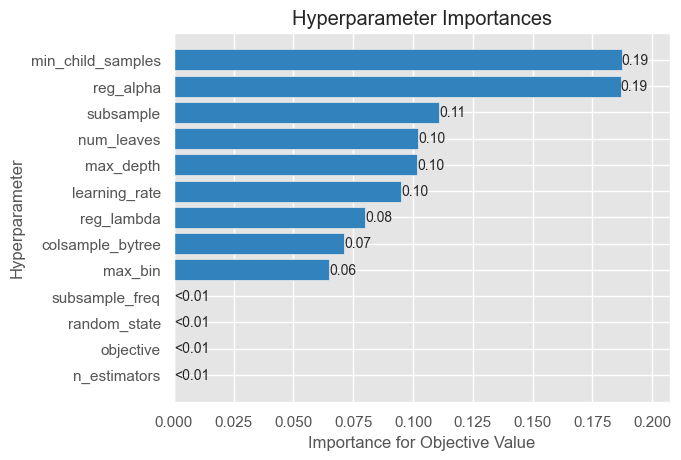

In [16]:
plot_param_importances(study);

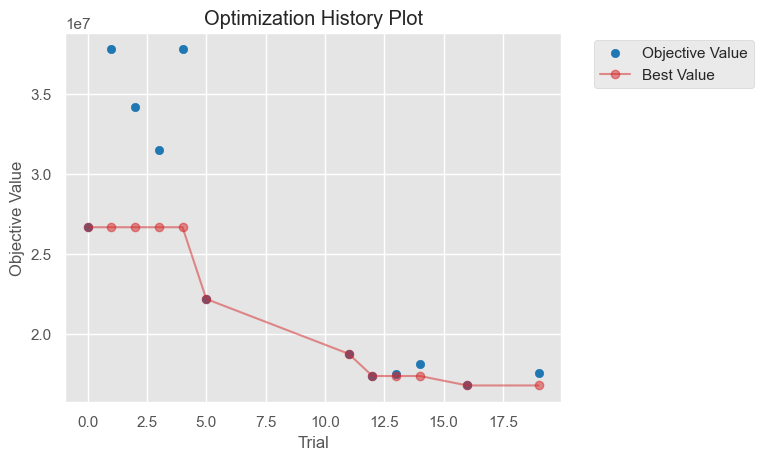

In [17]:
plot_optimization_history(study);

# Обучение на лучших параметрах

In [21]:
reg_optuna = LGBMRegressor(**study.best_params, silent=True, verbose=-1)
reg_optuna.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.5078236327312899,
              learning_rate=0.14740207467503272, max_bin=2670, max_depth=9,
              n_estimators=200, num_leaves=860, objective='mae',
              random_state=10, reg_alpha=48, reg_lambda=93, silent=True,
              subsample=0.7688511524644333, subsample_freq=1, verbose=-1)

In [22]:
metrics_optuna = {}

metrics_optuna['test'] = create_dict_metrics(y_test=y_test,
                                      y_predict=reg_optuna.predict(X_test),
                                      x_test=X_test,
                                      target_is_log=train['log_target'])

metrics_optuna['train'] = create_dict_metrics(y_test=y_train,
                                       y_predict=reg_optuna.predict(X_train),
                                       x_test=X_train,
                                       target_is_log=train['log_target'])

overfitting_optuna = check_overfitting(metrics_optuna)

In [23]:
metrics_baseline

{'test': {'mae': 14953964.227, 'r2_adjusted': 0.77, 'wape': 38.253},
 'train': {'mae': 9945923.751, 'r2_adjusted': 0.849, 'wape': 24.972}}

In [24]:
metrics_optuna

{'test': {'mae': 16115477.585, 'r2_adjusted': 0.73, 'wape': 41.224},
 'train': {'mae': 13768026.163, 'r2_adjusted': 0.774, 'wape': 34.568}}

In [25]:
overfitting_baseline

{'mae': 33.49, 'r2_adjusted': 10.26, 'wape': 34.72}

In [26]:
overfitting_optuna

{'mae': 14.57, 'r2_adjusted': 6.03, 'wape': 16.15}

После настройки с Optuna, точность модели снизилась (WAPE на 3%,  R2_adjusted на 0.04, MAE возрасла на ~1 млн). <br>При этом уровень переобучения значительно уменьшился.

In [27]:
# Сохраняем модель
joblib.dump(reg_optuna, os.path.join(train["model_path"]))
# Сохраняем объект study для вывода графиков в UI
joblib.dump(study, os.path.join(train["study_path"]))

['../models/study.joblib']

In [28]:
def save_metrics(data_x: pd.DataFrame,
                 data_y: pd.Series,
                 model: object,
                 metric_path: str,
                 target_is_log: bool) -> None:
    """
    Получение и сохранение метрик
    :param data_x: объект-признаки
    :param data_y: целевая переменная
    :param model: модель
    :param metric_path: путь для сохранения метрик
    :param target_is_log: условие логарифмированной целевой переменной
    """
    result_metrics = create_dict_metrics(y_test=data_y,
                                         y_predict=model.predict(data_x),
                                         x_test=data_x,
                                         target_is_log=target_is_log)
    
    with open(metric_path, 'w', encoding='utf-8') as file:
        json.dump(result_metrics, file, indent=4, ensure_ascii=False)

# Сохраняем метрики на train и на test для вывода в UI
save_metrics(data_x=X_test,
             data_y=y_test,
             model=reg_optuna,
             metric_path=train['metrics_path_test'],
             target_is_log=train['log_target'])

save_metrics(data_x=X_train,
             data_y=y_train,
             model=reg_optuna,
             metric_path=train['metrics_path_train'],
             target_is_log=train['log_target'])